In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.utils.parametrize as parametrize
import h5py
from pykeops.torch import LazyTensor, generic_sum
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from scipy.special import gamma, kv
from scipy.stats import mode

import sys
sys.path.append("../..")
from losses import squared_error, relative_error
from rkhs_functions import make_kernel, RKHSFunction
from training_functions import train_rkhs_pde
from helper import trapezoid_rule, standard_deviation
from constraints import FlipSymmetric, Symmetric, Causal, DomainMask

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

use_cuda = torch.cuda.is_available()
tensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


In [2]:
###############################################################################
#   Generate Heat Equation Forcings and Solutions
###############################################################################

m = 50
kernel_width = 0.1

data = h5py.File("../../generate_data/heateq_exponentialKLE.hdf5", "r")
x_train, t_train = data[f"mesh{m}"].attrs["mesh"]
mx_train = len(x_train)
mt_train = len(t_train)

num_train = 100
fs_train = data[f"mesh{m}"][f"kernelwidth{kernel_width}"]["forcings"][:num_train, :]
us_train_clean = data[f"mesh{m}"][f"kernelwidth{kernel_width}"]["solutions"][:num_train, :]

x_train = torch.from_numpy(x_train).type(tensor)
t_train = torch.from_numpy(t_train).type(tensor)
fs_train = torch.from_numpy(fs_train).type(tensor)
us_train_clean = torch.from_numpy(us_train_clean).type(tensor)

# add noise to solutions at a given SNR
sigma = 0.2
us_train = us_train_clean + sigma * standard_deviation(us_train_clean) * torch.randn(num_train, mx_train*mt_train).type(tensor)

# true Green's kernel
mx_true = 50
mt_true = 50
x_true = torch.linspace(0, 1, mx_true).type(tensor)
t_true = torch.linspace(0, 1, mt_true).type(tensor)
X, T, Y, S = torch.meshgrid(x_true, t_true, x_true, t_true)
Tdiff = S - T
G_true = torch.zeros(mx_true, mt_true, mx_true, mt_true).type(tensor)
modes = 500 #mx_true
a = 0.1
L = 1
for k in range(1, modes):
    p = math.pi*k/L
    G_true += 2/L * torch.sin(p*X) * torch.sin(p*Y) * torch.exp(-a*p**2*Tdiff)
G_true[Tdiff < 0] = 0
G_true[T <= 0] = 0 # effect of PDE simulation
#G_true = G_true.view(mx_true*mt_true, mx_true*mt_true).double()

# Green's kernel with infinite diagonal T = S removed
inf_coords = torch.logical_and(T == S, S > 0)
G_true_finite = torch.zeros_like(G_true)
G_true_finite[:] = G_true
G_true_finite[inf_coords] = torch.nan
#G_true_finite[inf_coords.view(mx_true*mt_true, mx_true*mt_true)] = torch.nan

/home/gridsan/gstepaniants/.local/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Solve Heat Equation with Dense Space-Symmetric Time-Causal Kernel

In [ ]:
mx_weight = mx_train
mt_weight = mt_train
x_weight = torch.linspace(x_train.min(), x_train.max(), mx_weight).type(tensor)
t_weight = torch.linspace(t_train.min(), t_train.max(), mt_weight).type(tensor)

kernel = "Exponential"
rkhs_kernel_width = 1/mx_weight

lmbda = 2e-7

epochs = 50
plotting_freq = 10
batch_size = 100
learning_rate = None

ind_divisor = 1
greens_out_meshes = (x_train, t_train, x_train, t_train)
greens_out_meshes_true = (x_true, t_true, x_true, t_true)
greens_weight_meshes = (x_weight, t_weight, x_weight, t_weight)
greens_quadrature = trapezoid_rule(greens_weight_meshes).flatten()

#Symmetric((mx_weight, mt_weight, mx_weight, mt_weight), 0, 2)
X, T, Y, S = torch.meshgrid(x_train, t_train, x_train, t_train)
Xi, Tau, Eta, Sigma = torch.meshgrid(x_weight, t_weight, x_weight, t_weight)
greens_weight_parametrizations_large = [#Causal((mx_weight, mt_weight, mx_weight, mt_weight), 1, 3),
                                  DomainMask((mx_weight, mt_weight, mx_weight, mt_weight), Sigma>0)]

def greens_transform_output_large(G, meshes):
    sizes = [len(x) for x in meshes]
    _, T, _, _ = torch.meshgrid(*meshes)
    #G = greens_weight_parametrizations_large[0](G, dims=sizes)
    G = greens_weight_parametrizations_large[0](G, dims=sizes, mask=(T>0))
    return G

def plotting_function(us_train_hat):
    example_ind = 0
    u = us_train[example_ind, :].cpu().view(mx_train, mt_train)
    u_hat = us_train_hat[example_ind, :].cpu().view(mx_train, mt_train)
    plt.figure(1)
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Training Output Example', fontweight='bold')
    im = axs[0].pcolormesh(x_train.cpu(), t_train.cpu(), u.T)
    axs[0].set_aspect(1)
    axs[0].set_title("$u$")
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('t')
    divider = make_axes_locatable(axs[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    im = axs[1].pcolormesh(x_train.cpu(), t_train.cpu(), u_hat.detach().T)
    axs[1].set_aspect(1)
    axs[1].set_title("$\widehat{u}$")
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('t')
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.tight_layout()
    plt.show()

In [ ]:
f_size = math.prod([len(x) for x in greens_out_meshes[:ind_divisor+1]])
f_size_true = math.prod([len(x) for x in greens_out_meshes_true[:ind_divisor+1]])
f_quadrature = trapezoid_rule(greens_out_meshes[:ind_divisor+1]).flatten()
u_size = math.prod([len(x) for x in greens_out_meshes[ind_divisor+1:]])
u_size_true = math.prod([len(x) for x in greens_out_meshes_true[ind_divisor+1:]])
u_quadrature = trapezoid_rule(greens_out_meshes[ind_divisor+1:]).flatten()

In [ ]:
# Fit smooth Green's function in RKHS to heat equation
greens_function, _, _, _, res, G_res, _, G_norms, _ = \
    train_rkhs_pde(fs_train, us_train, ind_divisor, kernel, rkhs_kernel_width,
                   greens_out_meshes, greens_weight_meshes,
                   #greens_out_meshes_true=greens_out_meshes_true, G_true=G_true,
                   greens_lmbda=lmbda,
                   batch_size=batch_size, epochs=epochs,
                   greens_learning_rate=None,
                   greens_weight_parametrizations=greens_weight_parametrizations,
                   greens_transform_output=greens_transform_output,
                   plotting_function=plotting_function, plotting_freq=plotting_freq, verbal=True)

torch.save(greens_function.state_dict(), "heat_eq_greens_function_large.pkl")

In [ ]:
greens_function_large.update_mesh(greens_out_meshes_true)
G = greens_function_large()
#G = symmetry_transform(G, dims=X.shape) # symmetry constraint
#G = causal_transform(G, dims=X.shape) # causal constraint
#G = domain_mask_transform(G, dims=X.shape, mask=(T>0)) # domain constraint
G = torch.reshape(G, (mx_true*mt_true, mx_true*mt_true))

fig, axs = plt.subplots(1, 2)
im = axs[0].pcolormesh(t_true.cpu(), t_true.cpu(), G[10*mt_true:11*mt_true, 10*mt_true:11*mt_true].cpu().detach().T)
axs[0].set_aspect(1)
axs[0].set_title("Estimated Green's Function")
axs[0].set_xlabel('t')
axs[0].set_ylabel('s')

im = axs[1].pcolormesh(t_true.cpu(), t_true.cpu(), G_true_finite[10*mt_true:11*mt_true, 10*mt_true:11*mt_true].cpu().detach().T)
axs[1].set_aspect(1)
axs[1].set_title("True Green's Function")
axs[1].set_xlabel('t')
axs[1].set_ylabel('s')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.0, 0.25, 0.05, 0.5])
fig.colorbar(im, cax=cbar_ax)
fig.tight_layout()
plt.show()


In [ ]:
greens_weight = torch.load("heat_eq_greens_function_large.pkl")['parametrizations.weight.original']
greens_function_large = RKHSFunction(greens_out_meshes_true, greens_weight_meshes,
                                   kernel=kernel, sigma=rkhs_kernel_width, dtype=torch.cuda.FloatTensor,
                                   weight_parametrizations=greens_weight_parametrizations_large,
                                   transform_output=greens_transform_output_large)
greens_function_large.parametrizations.weight.original = torch.nn.Parameter(greens_weight)

## Solve Heat Equation with Convolutional Space-Symmetric Time-Causal Kernel

In [3]:
mx_weight = mx_train
mt_weight = mt_train
x_weight = torch.linspace(x_train.min(), x_train.max(), mx_weight).type(tensor)
t_weight = torch.linspace(t_train.min(), t_train.max(), mt_weight).type(tensor)

f_quadrature = trapezoid_rule((x_train, t_train)).flatten()
u_quadrature = trapezoid_rule((x_train, t_train)).flatten()

kernel = "Exponential"
rkhs_kernel_width = 2/mx_weight

epochs = 100
plotting_freq = 10
batch_size = 100
learning_rate = None

ind_divisor = 1
s_t_train = torch.concat((-t_train[1:].flip(0), t_train)).type(tensor)
s_t_true = torch.concat((-t_true[1:].flip(0), t_true)).type(tensor)
sigma_tau_weight = torch.concat((-t_weight[1:].flip(0), t_weight)).type(tensor)
greens_out_meshes = (x_train, x_train, s_t_train)
greens_out_meshes_true = (x_true, x_true, s_t_true)
greens_weight_meshes = (x_weight, x_weight, sigma_tau_weight)
greens_quadrature = trapezoid_rule(greens_weight_meshes).flatten()

X, Y, S_T = torch.meshgrid(x_train, x_train, s_t_train)
Xi, Eta, Sigma_Tau = torch.meshgrid(x_weight, x_weight, sigma_tau_weight)

def plotting_function(us_train_hat, example_ind = 0):
    u = us_train[example_ind, :].cpu().view(mx_train, mt_train)
    u_hat = us_train_hat[example_ind, :].cpu().view(mx_train, mt_train)
    plt.figure(1)
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Training Output Example', fontweight='bold')
    im = axs[0].pcolormesh(x_train.cpu(), t_train.cpu(), u.T)
    axs[0].set_aspect(1)
    axs[0].set_title("$u$")
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('t')
    divider = make_axes_locatable(axs[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    im = axs[1].pcolormesh(x_train.cpu(), t_train.cpu(), u_hat.detach().T)
    axs[1].set_aspect(1)
    axs[1].set_title("$\widehat{u}$")
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('t')
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.tight_layout()
    plt.show()

### Green's Function with Causal Constraints

Green's Function Learning Rate: 100
Epoch 1 Relative Error 139.83309936523438
First epoch had re = 139.83309936523438 > 1
Green's Function Learning Rate: 50
Epoch 1 Relative Error 69.48373413085938
First epoch had re = 69.48373413085938 > 1
Green's Function Learning Rate: 10
Epoch 1 Relative Error 13.211084365844727
First epoch had re = 13.211084365844727 > 1
Green's Function Learning Rate: 5
Epoch 1 Relative Error 6.1866631507873535
First epoch had re = 6.1866631507873535 > 1
Green's Function Learning Rate: 1
Epoch 1 Relative Error 0.7323312163352966
Epoch 2 Relative Error 0.7874612212181091
Epoch 3 Relative Error 0.49731481075286865
Epoch 4 Relative Error 0.4326555132865906
Epoch 5 Relative Error 0.5735911130905151
Epoch 6 Relative Error 0.6019273996353149
Epoch 7 Relative Error 0.49863746762275696
Epoch 8 Relative Error 0.3593652546405792
Epoch 9 Relative Error 0.3226620852947235


<Figure size 432x288 with 0 Axes>

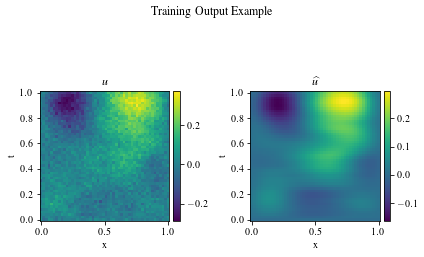

Epoch 10 Relative Error 0.39341843128204346
Epoch 11 Relative Error 0.4514055550098419
Epoch 12 Relative Error 0.44846227765083313
Epoch 13 Relative Error 0.3944054841995239
Epoch 14 Relative Error 0.32883962988853455
Epoch 15 Relative Error 0.30027422308921814
Epoch 16 Relative Error 0.3199562430381775
Epoch 17 Relative Error 0.3512429893016815
Epoch 18 Relative Error 0.36301109194755554
Epoch 19 Relative Error 0.34895241260528564


<Figure size 432x288 with 0 Axes>

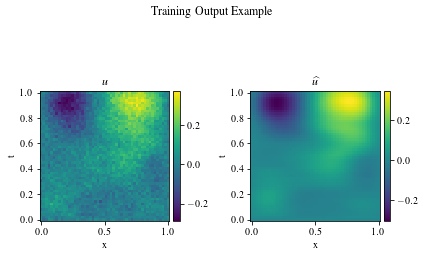

Epoch 20 Relative Error 0.3208281397819519
Epoch 21 Relative Error 0.2984771132469177
Epoch 22 Relative Error 0.2951832413673401
Epoch 23 Relative Error 0.30616024136543274
Epoch 24 Relative Error 0.3165210485458374
Epoch 25 Relative Error 0.31613436341285706
Epoch 26 Relative Error 0.304781049489975
Epoch 27 Relative Error 0.29007089138031006
Epoch 28 Relative Error 0.2816995084285736
Epoch 29 Relative Error 0.2839660942554474


<Figure size 432x288 with 0 Axes>

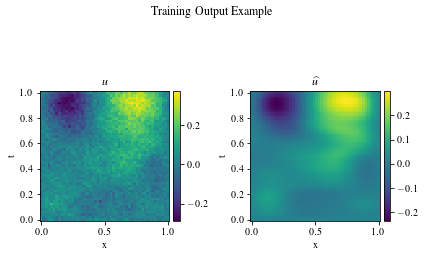

Epoch 30 Relative Error 0.2926912307739258
Epoch 31 Relative Error 0.30005183815956116
Epoch 32 Relative Error 0.3008615970611572
Epoch 33 Relative Error 0.29497215151786804
Epoch 34 Relative Error 0.28627973794937134
Epoch 35 Relative Error 0.2798088490962982
Epoch 36 Relative Error 0.27831119298934937
Epoch 37 Relative Error 0.28071150183677673
Epoch 38 Relative Error 0.28367286920547485
Epoch 39 Relative Error 0.2844308912754059


<Figure size 432x288 with 0 Axes>

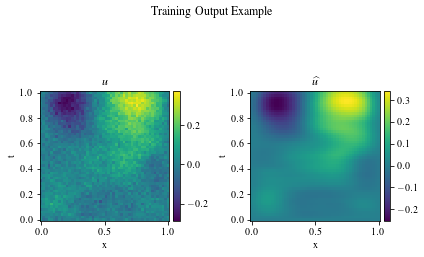

Epoch 40 Relative Error 0.28243717551231384
Epoch 41 Relative Error 0.279185026884079
Epoch 42 Relative Error 0.276819109916687
Epoch 43 Relative Error 0.27654483914375305
Epoch 44 Relative Error 0.27792686223983765
Epoch 45 Relative Error 0.2794877290725708
Epoch 46 Relative Error 0.2799181044101715
Epoch 47 Relative Error 0.2789042890071869
Epoch 48 Relative Error 0.27713900804519653
Epoch 49 Relative Error 0.275689959526062


<Figure size 432x288 with 0 Axes>

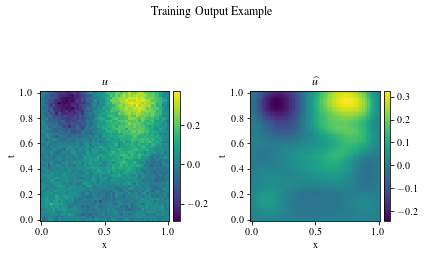

Epoch 50 Relative Error 0.27522870898246765
Epoch 51 Relative Error 0.27564918994903564
Epoch 52 Relative Error 0.2762860953807831
Epoch 53 Relative Error 0.27647310495376587
Epoch 54 Relative Error 0.27598872780799866
Epoch 55 Relative Error 0.2751208543777466
Epoch 56 Relative Error 0.27438634634017944
Epoch 57 Relative Error 0.2741453945636749
Epoch 58 Relative Error 0.27438172698020935
Epoch 59 Relative Error 0.27477169036865234


<Figure size 432x288 with 0 Axes>

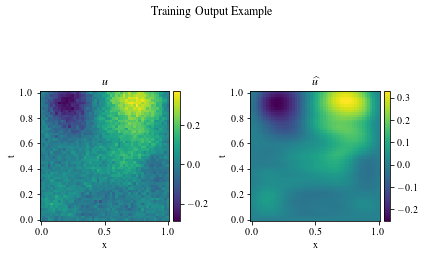

Epoch 60 Relative Error 0.2749457359313965
Epoch 61 Relative Error 0.27473145723342896
Epoch 62 Relative Error 0.2742256820201874
Epoch 63 Relative Error 0.2736838459968567
Epoch 64 Relative Error 0.27333149313926697
Epoch 65 Relative Error 0.27323248982429504
Epoch 66 Relative Error 0.273288369178772
Epoch 67 Relative Error 0.273342490196228
Epoch 68 Relative Error 0.27329832315444946
Epoch 69 Relative Error 0.27317020297050476


<Figure size 432x288 with 0 Axes>

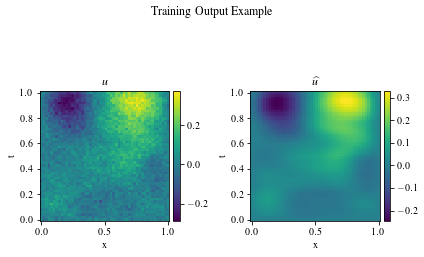

Epoch 70 Relative Error 0.2730468809604645
Epoch 71 Relative Error 0.2730103135108948
Epoch 72 Relative Error 0.2730728089809418
Epoch 73 Relative Error 0.27317291498184204
Epoch 74 Relative Error 0.2732228934764862
Epoch 75 Relative Error 0.2731676399707794
Epoch 76 Relative Error 0.2730143666267395
Epoch 77 Relative Error 0.27281874418258667
Epoch 78 Relative Error 0.2726443111896515
Epoch 79 Relative Error 0.2725256383419037


<Figure size 432x288 with 0 Axes>

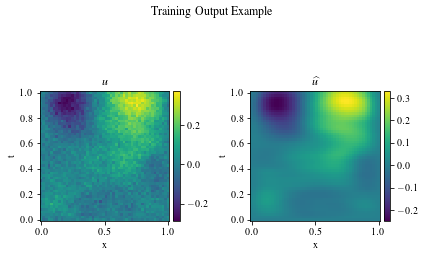

Epoch 80 Relative Error 0.2724573612213135
Epoch 81 Relative Error 0.27241063117980957
Epoch 82 Relative Error 0.2723601460456848
Epoch 83 Relative Error 0.2723012864589691
Epoch 84 Relative Error 0.272248238325119
Epoch 85 Relative Error 0.2722183167934418
Epoch 86 Relative Error 0.2722160518169403
Epoch 87 Relative Error 0.27222856879234314
Epoch 88 Relative Error 0.27223363518714905
Epoch 89 Relative Error 0.2722133994102478


<Figure size 432x288 with 0 Axes>

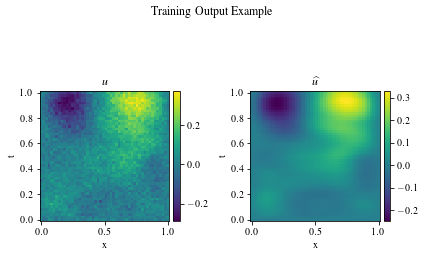

Epoch 90 Relative Error 0.2721638083457947
Epoch 91 Relative Error 0.27209460735321045
Epoch 92 Relative Error 0.2720213532447815
Epoch 93 Relative Error 0.2719559967517853
Epoch 94 Relative Error 0.271901935338974
Epoch 95 Relative Error 0.2718559801578522
Epoch 96 Relative Error 0.2718133330345154
Epoch 97 Relative Error 0.2717723548412323
Epoch 98 Relative Error 0.2717352509498596
Epoch 99 Relative Error 0.2717052698135376


<Figure size 432x288 with 0 Axes>

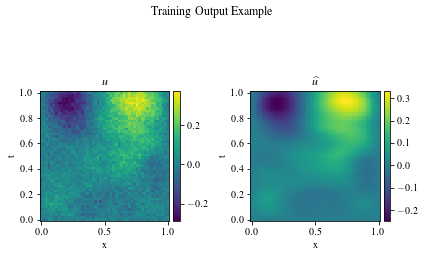

Epoch 100 Relative Error 0.2716831862926483


In [13]:
lmbda = 2e-7

greens_weight_parametrizations = [#Symmetric((mx_weight, mx_weight, 2*mt_weight-1), 0, 1, tri="both"),
                                  FlipSymmetric((mx_weight, mx_weight, 2*mt_weight-1), [2], direction="both"),
                                  DomainMask((mx_weight, mx_weight, 2*mt_weight-1), Sigma_Tau>=0)]

T_mask = torch.ones((mx_train, mt_train, mx_train, mt_train)).bool()
T_mask[:, 0, :, :] = 0
domain_mask_transform = DomainMask((mx_train, mt_train, mx_train, mt_train), T_mask)
def greens_transform_output(Gconv, meshes):
    sizes = [len(x) for x in meshes]
    _, _, S_T = torch.meshgrid(*meshes)
    #Gconv = greens_weight_parametrizations[0](Gconv, dims=sizes, tri="both") # symmetry constraint
    Gconv = greens_weight_parametrizations[0](Gconv, dims=sizes, direction="both") # flip symmetry constraint
    Gconv = greens_weight_parametrizations[1](Gconv, dims=sizes, mask=(S_T>=0)) # causal constraint
    Gconv = torch.reshape(Gconv, sizes)
    mt = sizes[-1]//2 + 1
    G = Gconv.unfold(-1, mt, 1).flip(-1).reshape((sizes[0], sizes[1], mt, mt))
    G = G.permute((0, 3, 1, 2))
    
    # set Green's function to zero at t = 0
    T_mask = torch.ones((sizes[0], mt, sizes[1], mt)).bool()
    T_mask[:, 0, :, :] = 0
    G = domain_mask_transform(G, dims=(sizes[0], mt, sizes[1], mt), mask=T_mask)
    return G

# Fit smooth Green's function in RKHS to heat equation with causal constraint
greens_function_causal, _, _, _, res_causal, G_res_causal, _, G_norms_causal, _ = \
    train_rkhs_pde(fs_train, us_train, ind_divisor, kernel, rkhs_kernel_width,
                   greens_out_meshes, greens_weight_meshes,
                   f_quadrature=f_quadrature, u_quadrature=u_quadrature,
                   #greens_out_meshes_true=greens_out_meshes_true, G_true=G_true,
                   greens_lmbda=lmbda,
                   batch_size=batch_size, epochs=epochs,
                   greens_learning_rate=None,
                   greens_weight_parametrizations=greens_weight_parametrizations,
                   greens_transform_output=greens_transform_output,
                   plotting_function=plotting_function, plotting_freq=plotting_freq, verbal=True)

torch.save(greens_function_causal.state_dict(), "heat_eq_greens_function_causal.pkl")

In [4]:
greens_weight_parametrizations_causal = [#Symmetric((mx_weight, mx_weight, 2*mt_weight-1), 0, 1, tri="both"),
                                  FlipSymmetric((mx_weight, mx_weight, 2*mt_weight-1), [2], direction="both"),
                                  DomainMask((mx_weight, mx_weight, 2*mt_weight-1), Sigma_Tau>=0)]

T_mask = torch.ones((mx_train, mt_train, mx_train, mt_train)).bool()
T_mask[:, 0, :, :] = 0
domain_mask_transform = DomainMask((mx_train, mt_train, mx_train, mt_train), T_mask)
def greens_transform_output_causal(Gconv, meshes):
    sizes = [len(x) for x in meshes]
    _, _, S_T = torch.meshgrid(*meshes)
    #Gconv = greens_weight_parametrizations_causal[0](Gconv, dims=sizes, tri="both") # symmetry constraint
    Gconv = greens_weight_parametrizations_causal[0](Gconv, dims=sizes, direction="both") # flip symmetry constraint
    Gconv = greens_weight_parametrizations_causal[1](Gconv, dims=sizes, mask=(S_T>=0)) # causal constraint
    Gconv = torch.reshape(Gconv, sizes)
    mt = sizes[-1]//2 + 1
    G = Gconv.unfold(-1, mt, 1).flip(-1).reshape((sizes[0], sizes[1], mt, mt))
    G = G.permute((0, 3, 1, 2))
    
    # set Green's function to zero at t = 0
    T_mask = torch.ones((sizes[0], mt, sizes[1], mt)).bool()
    T_mask[:, 0, :, :] = 0
    G = domain_mask_transform(G, dims=(sizes[0], mt, sizes[1], mt), mask=T_mask)
    return G

greens_weight = torch.load("heat_eq_greens_function_causal.pkl")['parametrizations.weight.original']
greens_function_causal = RKHSFunction(greens_out_meshes_true, greens_weight_meshes,
                                   kernel=kernel, sigma=rkhs_kernel_width, dtype=torch.cuda.FloatTensor,
                                   weight_parametrizations=greens_weight_parametrizations_causal,
                                   transform_output=greens_transform_output_causal)
greens_function_causal.parametrizations.weight.original = torch.nn.Parameter(greens_weight)

[KeOps] Generating code for formula Sum_Reduction(Exp(-Sqrt(Sum((Var(0,3,0)-Var(1,3,1))**2)))*Var(2,1,1),0) ... OK


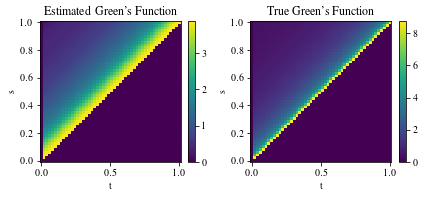

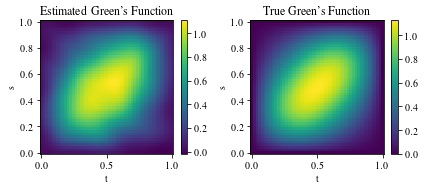

In [5]:
greens_function_causal.update_mesh(greens_out_meshes_true)
G = greens_function_causal()

fig, axs = plt.subplots(1, 2)
im = axs[0].pcolormesh(t_true.cpu(), t_true.cpu(), G[10, :, 11, :].cpu().detach().T)
axs[0].set_aspect(1)
axs[0].set_title("Estimated Green's Function")
axs[0].set_xlabel('t')
axs[0].set_ylabel('s')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1].pcolormesh(t_true.cpu(), t_true.cpu(), G_true.view(mx_true, mt_true, mx_true, mt_true)[10, :, 11, :].cpu().detach().T)
axs[1].set_aspect(1)
axs[1].set_title("True Green's Function")
axs[1].set_xlabel('t')
axs[1].set_ylabel('s')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im, cax=cax, orientation='vertical')
fig.tight_layout()

fig, axs = plt.subplots(1, 2)
im = axs[0].pcolormesh(t_true.cpu(), t_true.cpu(), G[:, 1, :, 30].cpu().detach().T)
axs[0].set_aspect(1)
axs[0].set_title("Estimated Green's Function")
axs[0].set_xlabel('t')
axs[0].set_ylabel('s')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1].pcolormesh(t_true.cpu(), t_true.cpu(), G_true.view(mx_true, mt_true, mx_true, mt_true)[:, 1, :, 30].cpu().detach().T)
axs[1].set_aspect(1)
axs[1].set_title("True Green's Function")
axs[1].set_xlabel('t')
axs[1].set_ylabel('s')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im, cax=cax, orientation='vertical')
fig.tight_layout()

plt.show()

### Green's Function without Causal Constraints

Green's Function Learning Rate: 100
Epoch 1 Relative Error 274.33575439453125
First epoch had re = 274.33575439453125 > 1
Green's Function Learning Rate: 50
Epoch 1 Relative Error 136.75587463378906
First epoch had re = 136.75587463378906 > 1
Green's Function Learning Rate: 10
Epoch 1 Relative Error 26.696306228637695
First epoch had re = 26.696306228637695 > 1
Green's Function Learning Rate: 5
Epoch 1 Relative Error 12.944598197937012
First epoch had re = 12.944598197937012 > 1
Green's Function Learning Rate: 1
Epoch 1 Relative Error 2.006767749786377
First epoch had re = 2.006767749786377 > 1
Green's Function Learning Rate: 0.5
Epoch 1 Relative Error 0.787858247756958
Epoch 2 Relative Error 0.7268961668014526
Epoch 3 Relative Error 0.5424207448959351
Epoch 4 Relative Error 0.5826097130775452
Epoch 5 Relative Error 0.5991727113723755
Epoch 6 Relative Error 0.5097808837890625
Epoch 7 Relative Error 0.42507800459861755
Epoch 8 Relative Error 0.43854594230651855
Epoch 9 Relative Error 0.

<Figure size 432x288 with 0 Axes>

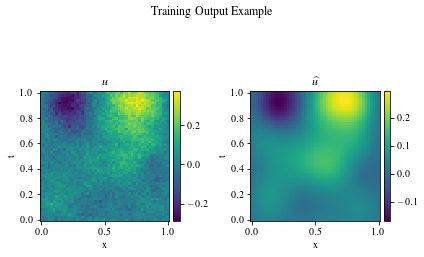

Epoch 10 Relative Error 0.47581833600997925
Epoch 11 Relative Error 0.4168299436569214
Epoch 12 Relative Error 0.35520029067993164
Epoch 13 Relative Error 0.34572654962539673
Epoch 14 Relative Error 0.378174364566803
Epoch 15 Relative Error 0.4015290439128876
Epoch 16 Relative Error 0.39060261845588684
Epoch 17 Relative Error 0.35337477922439575
Epoch 18 Relative Error 0.31815439462661743
Epoch 19 Relative Error 0.3108038604259491


<Figure size 432x288 with 0 Axes>

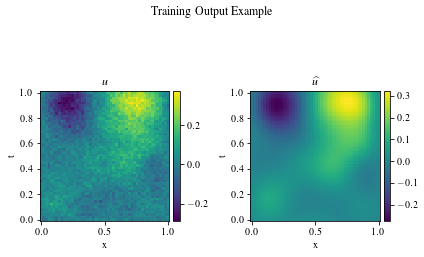

Epoch 20 Relative Error 0.32759279012680054
Epoch 21 Relative Error 0.3442305326461792
Epoch 22 Relative Error 0.34458601474761963
Epoch 23 Relative Error 0.3290966749191284
Epoch 24 Relative Error 0.30968987941741943
Epoch 25 Relative Error 0.29953324794769287
Epoch 26 Relative Error 0.30191150307655334
Epoch 27 Relative Error 0.30912724137306213
Epoch 28 Relative Error 0.3122626543045044
Epoch 29 Relative Error 0.3085497319698334


<Figure size 432x288 with 0 Axes>

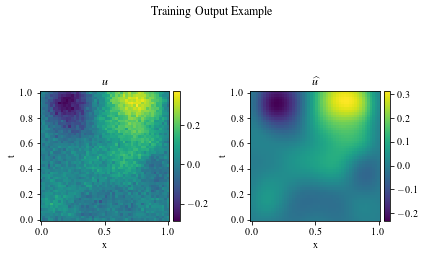

Epoch 30 Relative Error 0.30140024423599243
Epoch 31 Relative Error 0.2961021363735199
Epoch 32 Relative Error 0.29500874876976013
Epoch 33 Relative Error 0.29617515206336975
Epoch 34 Relative Error 0.296223908662796
Epoch 35 Relative Error 0.29377108812332153
Epoch 36 Relative Error 0.29028064012527466
Epoch 37 Relative Error 0.2882915437221527
Epoch 38 Relative Error 0.28888675570487976
Epoch 39 Relative Error 0.2907522916793823


<Figure size 432x288 with 0 Axes>

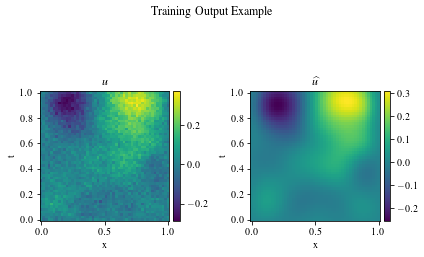

Epoch 40 Relative Error 0.29155099391937256
Epoch 41 Relative Error 0.2899939715862274
Epoch 42 Relative Error 0.28676557540893555
Epoch 43 Relative Error 0.2838190793991089
Epoch 44 Relative Error 0.28275445103645325
Epoch 45 Relative Error 0.28361204266548157
Epoch 46 Relative Error 0.28506234288215637
Epoch 47 Relative Error 0.2856408953666687
Epoch 48 Relative Error 0.28483039140701294
Epoch 49 Relative Error 0.2832254469394684


<Figure size 432x288 with 0 Axes>

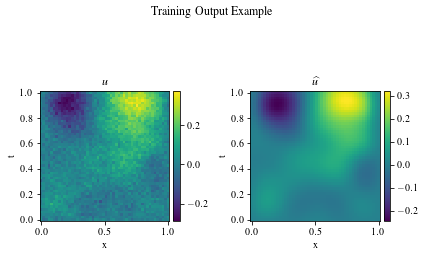

Epoch 50 Relative Error 0.2818717062473297
Epoch 51 Relative Error 0.28140702843666077
Epoch 52 Relative Error 0.28167858719825745
Epoch 53 Relative Error 0.2820446193218231
Epoch 54 Relative Error 0.28197789192199707
Epoch 55 Relative Error 0.28143152594566345
Epoch 56 Relative Error 0.2807510495185852
Epoch 57 Relative Error 0.28030815720558167
Epoch 58 Relative Error 0.28020185232162476
Epoch 59 Relative Error 0.2802470922470093


<Figure size 432x288 with 0 Axes>

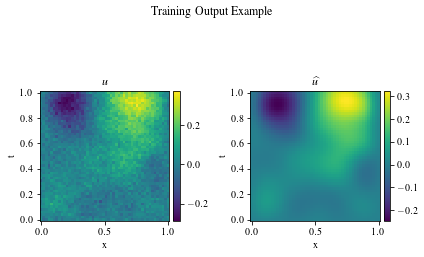

Epoch 60 Relative Error 0.2801956534385681
Epoch 61 Relative Error 0.27995526790618896
Epoch 62 Relative Error 0.2796293795108795
Epoch 63 Relative Error 0.2793842554092407
Epoch 64 Relative Error 0.2792899012565613
Epoch 65 Relative Error 0.27927401661872864
Epoch 66 Relative Error 0.27920791506767273
Epoch 67 Relative Error 0.27902817726135254
Epoch 68 Relative Error 0.2787840962409973
Epoch 69 Relative Error 0.27858206629753113


<Figure size 432x288 with 0 Axes>

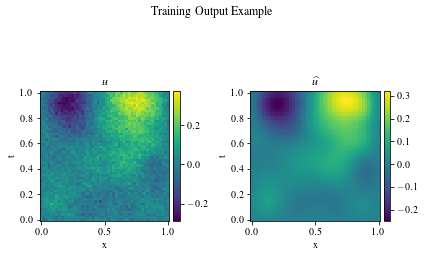

Epoch 70 Relative Error 0.27848780155181885
Epoch 71 Relative Error 0.2784739136695862
Epoch 72 Relative Error 0.27845075726509094
Epoch 73 Relative Error 0.2783452570438385
Epoch 74 Relative Error 0.27815669775009155
Epoch 75 Relative Error 0.2779495418071747
Epoch 76 Relative Error 0.27779674530029297
Epoch 77 Relative Error 0.27772486209869385
Epoch 78 Relative Error 0.2777021825313568
Epoch 79 Relative Error 0.27767184376716614


<Figure size 432x288 with 0 Axes>

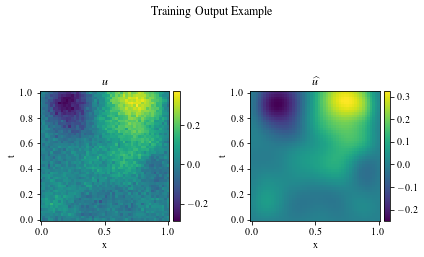

Epoch 80 Relative Error 0.2775971293449402
Epoch 81 Relative Error 0.27748316526412964
Epoch 82 Relative Error 0.2773635685443878
Epoch 83 Relative Error 0.2772693634033203
Epoch 84 Relative Error 0.2772071361541748
Epoch 85 Relative Error 0.2771603465080261
Epoch 86 Relative Error 0.2771074175834656
Epoch 87 Relative Error 0.27703872323036194
Epoch 88 Relative Error 0.2769600450992584
Epoch 89 Relative Error 0.27688294649124146


<Figure size 432x288 with 0 Axes>

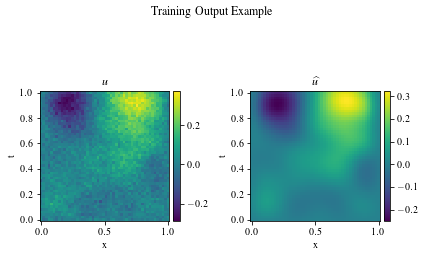

Epoch 90 Relative Error 0.2768132984638214
Epoch 91 Relative Error 0.27674761414527893
Epoch 92 Relative Error 0.27667829394340515
Epoch 93 Relative Error 0.2766017019748688
Epoch 94 Relative Error 0.2765214443206787
Epoch 95 Relative Error 0.2764449417591095
Epoch 96 Relative Error 0.27637749910354614
Epoch 97 Relative Error 0.2763186991214752
Epoch 98 Relative Error 0.27626416087150574
Epoch 99 Relative Error 0.27620989084243774


<Figure size 432x288 with 0 Axes>

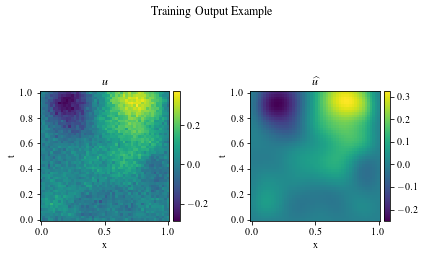

Epoch 100 Relative Error 0.27615538239479065


In [12]:
lmbda = 2e-7

greens_weight_parametrizations_conv = []

T_mask = torch.ones((mx_train, mt_train, mx_train, mt_train)).bool()
T_mask[:, 0, :, :] = 0
domain_mask_transform = DomainMask((mx_train, mt_train, mx_train, mt_train), T_mask)
def greens_transform_output_conv(Gconv, meshes):
    sizes = [len(x) for x in meshes]
    Gconv = torch.reshape(Gconv, sizes)
    mt = sizes[-1]//2 + 1
    G = Gconv.unfold(-1, mt, 1).flip(-1).reshape((sizes[0], sizes[1], mt, mt))
    G = G.permute((0, 3, 1, 2))
    
    # set Green's function to zero at t = 0
    T_mask = torch.ones((sizes[0], mt, sizes[1], mt)).bool()
    T_mask[:, 0, :, :] = 0
    G = domain_mask_transform(G, dims=(sizes[0], mt, sizes[1], mt), mask=T_mask)
    return G

# Fit smooth Green's function in RKHS to heat equation without causal constraint
greens_function_conv, _, _, _, res, G_res, _, G_norms, _ = \
    train_rkhs_pde(fs_train, us_train, ind_divisor, kernel, rkhs_kernel_width,
                   greens_out_meshes, greens_weight_meshes,
                   f_quadrature=f_quadrature, u_quadrature=u_quadrature,
                   #greens_out_meshes_true=greens_out_meshes_true, G_true=G_true,
                   greens_lmbda=lmbda,
                   batch_size=batch_size, epochs=epochs,
                   greens_learning_rate=None,
                   greens_weight_parametrizations=greens_weight_parametrizations_conv,
                   greens_transform_output=greens_transform_output_conv,
                   plotting_function=plotting_function, plotting_freq=plotting_freq, verbal=True)

torch.save(greens_function_conv.state_dict(), "heat_eq_greens_function_conv.pkl")

In [6]:
greens_weight_parametrizations_conv = []

T_mask = torch.ones((mx_train, mt_train, mx_train, mt_train)).bool()
T_mask[:, 0, :, :] = 0
domain_mask_transform = DomainMask((mx_train, mt_train, mx_train, mt_train), T_mask)
def greens_transform_output_conv(Gconv, meshes):
    sizes = [len(x) for x in meshes]
    Gconv = torch.reshape(Gconv, sizes)
    mt = sizes[-1]//2 + 1
    G = Gconv.unfold(-1, mt, 1).flip(-1).reshape((sizes[0], sizes[1], mt, mt))
    G = G.permute((0, 3, 1, 2))
    
    # set Green's function to zero at t = 0
    T_mask = torch.ones((sizes[0], mt, sizes[1], mt)).bool()
    T_mask[:, 0, :, :] = 0
    G = domain_mask_transform(G, dims=(sizes[0], mt, sizes[1], mt), mask=T_mask)
    return G

greens_weight = torch.load("heat_eq_greens_function_conv.pkl")['weight']
greens_function_conv = RKHSFunction(greens_out_meshes_true, greens_weight_meshes,
                                   kernel=kernel, sigma=rkhs_kernel_width, dtype=torch.cuda.FloatTensor,
                                   weight_parametrizations=greens_weight_parametrizations_conv,
                                   transform_output=greens_transform_output_conv)
greens_function_conv.weight = torch.nn.Parameter(greens_weight)

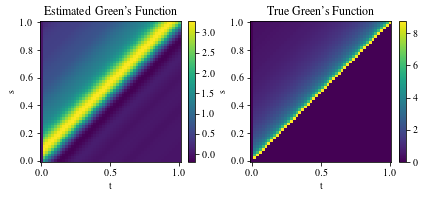

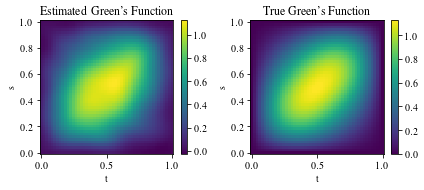

In [7]:
greens_function_conv.update_mesh(greens_out_meshes_true)
G = greens_function_conv()

fig, axs = plt.subplots(1, 2)
im = axs[0].pcolormesh(t_true.cpu(), t_true.cpu(), G[10, :, 11, :].cpu().detach().T)
axs[0].set_aspect(1)
axs[0].set_title("Estimated Green's Function")
axs[0].set_xlabel('t')
axs[0].set_ylabel('s')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1].pcolormesh(t_true.cpu(), t_true.cpu(), G_true.view(mx_true, mt_true, mx_true, mt_true)[10, :, 11, :].cpu().detach().T)
axs[1].set_aspect(1)
axs[1].set_title("True Green's Function")
axs[1].set_xlabel('t')
axs[1].set_ylabel('s')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im, cax=cax, orientation='vertical')
fig.tight_layout()

fig, axs = plt.subplots(1, 2)
im = axs[0].pcolormesh(t_true.cpu(), t_true.cpu(), G[:, 1, :, 30].cpu().detach().T)
axs[0].set_aspect(1)
axs[0].set_title("Estimated Green's Function")
axs[0].set_xlabel('t')
axs[0].set_ylabel('s')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1].pcolormesh(t_true.cpu(), t_true.cpu(), G_true.view(mx_true, mt_true, mx_true, mt_true)[:, 1, :, 30].cpu().detach().T)
axs[1].set_aspect(1)
axs[1].set_title("True Green's Function")
axs[1].set_xlabel('t')
axs[1].set_ylabel('s')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im, cax=cax, orientation='vertical')
fig.tight_layout()

plt.show()

In [ ]:
greens_function.update_mesh(greens_out_meshes)
G = greens_function().reshape(f_size, f_size)

# compute the relative train error on the solutions
us_train_hat = (fs_train * f_quadrature) @ G
train_re = relative_error(us_train_hat, us_train, agg="mean").item()
print('Train Relative Error: ' + str(train_re))

# plot best and worst case train predictions
train_res = relative_error(us_train_hat, us_train)
best_re, best_ind = torch.min(train_res, 0)
worst_re, worst_ind = torch.max(train_res, 0)

print('Best Relative Error: ' + str(best_re.item()))
plotting_function(us_train_hat, example_ind = best_ind)

print('Worst Relative Error: ' + str(worst_re.item()))
plotting_function(us_train_hat, example_ind = worst_ind)

## Evaluate Causal and Noncausal Green's Functions on Test Data

In [15]:
# number of test samples
num_test = 500

kernel_width_sizes = [1e-2, 2.5e-2, 5e-2, 7.5e-2, 1e-1, 2.5e-1, 5e-1, 7.5e-1, 1.0, 2.5, 5.0, 7.5, 10.0]
mesh_sizes = [50, 75, 100, 150]

test_sigma = 0.0

test_mesh_res_conv = np.zeros((len(mesh_sizes), len(kernel_width_sizes)))
best_f_conv = np.empty((len(mesh_sizes), len(kernel_width_sizes)), dtype="object")
best_u_conv = np.empty((len(mesh_sizes), len(kernel_width_sizes)), dtype="object")
best_u_hat_conv = np.empty((len(mesh_sizes), len(kernel_width_sizes)), dtype="object")
best_res_conv = np.zeros((len(mesh_sizes), len(kernel_width_sizes)))
worst_f_conv = np.empty((len(mesh_sizes), len(kernel_width_sizes)), dtype="object")
worst_u_conv = np.empty((len(mesh_sizes), len(kernel_width_sizes)), dtype="object")
worst_u_hat_conv = np.empty((len(mesh_sizes), len(kernel_width_sizes)), dtype="object")
worst_res_conv = np.zeros((len(mesh_sizes), len(kernel_width_sizes)))
for i in range(len(mesh_sizes)):
    for j in range(len(kernel_width_sizes)):
        print(f'({i}, {j})')
        m = mesh_sizes[i]
        w = kernel_width_sizes[j]
        
        x_test, t_test = data[f"mesh{m}"].attrs["mesh"]
        mx_test = len(x_test)
        mt_test = len(t_test)

        fs_test = data[f"mesh{m}"][f"kernelwidth{w}"]["forcings"][-num_test:, :]
        us_test_clean = data[f"mesh{m}"][f"kernelwidth{w}"]["solutions"][-num_test:, :]

        x_test = torch.from_numpy(x_test).type(tensor)
        t_test = torch.from_numpy(t_test).type(tensor)
        fs_test = torch.from_numpy(fs_test).type(tensor)
        us_test_clean = torch.from_numpy(us_test_clean).type(tensor)
        
        # add noise to solutions at a given SNR
        sigma = 0
        us_test = us_test_clean + sigma * standard_deviation(us_test_clean) * torch.randn(num_test, mx_test*mt_test).type(tensor)
        
        s_t_test = torch.concat((-t_test[1:].flip(0), t_test)).type(tensor)
        greens_out_meshes_test = (x_test, x_test, s_t_test)
        f_size_test = mx_test*mt_test
        f_quadrature_test = trapezoid_rule((x_test, t_test)).flatten()
        u_size_test = mx_test*mt_test
        
        greens_function_conv.update_mesh(greens_out_meshes_test)
        G = greens_function_conv()
        G = torch.reshape(G, (f_size_test, u_size_test))
        
        us_test_hat = (fs_test * f_quadrature_test) @ G
        test_res = relative_error(us_test_hat, us_test)
        test_mesh_res_conv[i, j] = torch.mean(test_res).item()
        
        best_res_conv[i, j], best_ind = torch.min(test_res, 0)
        best_f_conv[i, j] = fs_test[best_ind, :].cpu().detach().view(m, m)
        best_u_conv[i, j] = us_test[best_ind, :].cpu().detach().view(m, m)
        best_u_hat_conv[i, j] = us_test_hat[best_ind, :].cpu().detach().view(m, m)
        
        worst_res_conv[i, j], worst_ind = torch.max(test_res, 0)
        worst_f_conv[i, j] = fs_test[worst_ind, :].cpu().detach().view(m, m)
        worst_u_conv[i, j] = us_test[worst_ind, :].cpu().detach().view(m, m)
        worst_u_hat_conv[i, j] = us_test_hat[worst_ind, :].cpu().detach().view(m, m)

np.savez("test_results_conv.npz", test_mesh_res=test_mesh_res_conv,
         best_f=best_f_conv, best_u=best_u_conv, best_u_hat=best_u_hat_conv, best_res=best_res_conv,
         worst_f=worst_f_conv, worst_u=worst_u_conv, worst_u_hat=worst_u_hat_conv, worst_res=worst_res_conv)

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(0, 10)
(0, 11)
(0, 12)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(1, 11)
(1, 12)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(2, 10)
(2, 11)
(2, 12)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(3, 10)
(3, 11)
(3, 12)


In [16]:
###############################################################################
#   Test Functional Neural Network on New Mesh Sizes
###############################################################################

# number of test samples
num_test = 500

kernel_width_sizes = [1e-2, 2.5e-2, 5e-2, 7.5e-2, 1e-1, 2.5e-1, 5e-1, 7.5e-1, 1.0, 2.5, 5.0, 7.5, 10.0]
mesh_sizes = [50, 75, 100, 150]

test_sigma = 0.0

test_mesh_res_causal = np.zeros((len(mesh_sizes), len(kernel_width_sizes)))
best_f_causal = np.empty((len(mesh_sizes), len(kernel_width_sizes)), dtype="object")
best_u_causal = np.empty((len(mesh_sizes), len(kernel_width_sizes)), dtype="object")
best_u_hat_causal = np.empty((len(mesh_sizes), len(kernel_width_sizes)), dtype="object")
best_res_causal = np.zeros((len(mesh_sizes), len(kernel_width_sizes)))
worst_f_causal = np.empty((len(mesh_sizes), len(kernel_width_sizes)), dtype="object")
worst_u_causal = np.empty((len(mesh_sizes), len(kernel_width_sizes)), dtype="object")
worst_u_hat_causal = np.empty((len(mesh_sizes), len(kernel_width_sizes)), dtype="object")
worst_res_causal = np.zeros((len(mesh_sizes), len(kernel_width_sizes)))
for i in range(len(mesh_sizes)):
    for j in range(len(kernel_width_sizes)):
        print(f'({i}, {j})')
        m = mesh_sizes[i]
        w = kernel_width_sizes[j]
        
        x_test, t_test = data[f"mesh{m}"].attrs["mesh"]
        mx_test = len(x_test)
        mt_test = len(t_test)

        fs_test = data[f"mesh{m}"][f"kernelwidth{w}"]["forcings"][-num_test:, :]
        us_test_clean = data[f"mesh{m}"][f"kernelwidth{w}"]["solutions"][-num_test:, :]

        x_test = torch.from_numpy(x_test).type(tensor)
        t_test = torch.from_numpy(t_test).type(tensor)
        fs_test = torch.from_numpy(fs_test).type(tensor)
        us_test_clean = torch.from_numpy(us_test_clean).type(tensor)
        
        # add noise to solutions at a given SNR
        sigma = 0
        us_test = us_test_clean + sigma * standard_deviation(us_test_clean) * torch.randn(num_test, mx_test*mt_test).type(tensor)
        
        s_t_test = torch.concat((-t_test[1:].flip(0), t_test)).type(tensor)
        greens_out_meshes_test = (x_test, x_test, s_t_test)
        f_size_test = mx_test*mt_test
        f_quadrature_test = trapezoid_rule((x_test, t_test)).flatten()
        u_size_test = mx_test*mt_test
        
        greens_function_causal.update_mesh(greens_out_meshes_test)
        G = greens_function_causal()
        G = torch.reshape(G, (f_size_test, u_size_test))
        
        us_test_hat = (fs_test * f_quadrature_test) @ G
        test_res = relative_error(us_test_hat, us_test)
        test_mesh_res_causal[i, j] = torch.mean(test_res).item()
        
        best_res_causal[i, j], best_ind = torch.min(test_res, 0)
        best_f_causal[i, j] = fs_test[best_ind, :].cpu().detach().view(m, m)
        best_u_causal[i, j] = us_test[best_ind, :].cpu().detach().view(m, m)
        best_u_hat_causal[i, j] = us_test_hat[best_ind, :].cpu().detach().view(m, m)
        
        worst_res_causal[i, j], worst_ind = torch.max(test_res, 0)
        worst_f_causal[i, j] = fs_test[worst_ind, :].cpu().detach().view(m, m)
        worst_u_causal[i, j] = us_test[worst_ind, :].cpu().detach().view(m, m)
        worst_u_hat_causal[i, j] = us_test_hat[worst_ind, :].cpu().detach().view(m, m)

np.savez("test_results_causal.npz", test_mesh_res=test_mesh_res_causal,
         best_f=best_f_causal, best_u=best_u_causal, best_u_hat=best_u_hat_causal, best_res=best_res_causal,
         worst_f=worst_f_causal, worst_u=worst_u_causal, worst_u_hat=worst_u_hat_causal, worst_res=worst_res_causal)

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(0, 10)
(0, 11)
(0, 12)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(1, 11)
(1, 12)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(2, 10)
(2, 11)
(2, 12)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(3, 10)
(3, 11)
(3, 12)


In [8]:
results = np.load("test_results_conv.npz", allow_pickle=True)
test_mesh_res_conv = results["test_mesh_res"]
best_f_conv = results["best_f"]
best_u_conv = results["best_u"]
best_u_hat_conv = results["best_u_hat"]
best_res_conv = results["best_res"]
worst_f_conv = results["worst_f"]
worst_u_conv = results["worst_u"]
worst_u_hat_conv = results["worst_u_hat"]
worst_res_conv = results["worst_res"]

results = np.load("test_results_causal.npz", allow_pickle=True)
test_mesh_res_causal = results["test_mesh_res"]
best_f_causal = results["best_f"]
best_u_causal = results["best_u"]
best_u_hat_causal = results["best_u_hat"]
best_res_causal = results["best_res"]
worst_f_causal = results["worst_f"]
worst_u_causal = results["worst_u"]
worst_u_hat_causal = results["worst_u_hat"]
worst_res_causal = results["worst_res"]

In [47]:
greens_function_conv.update_mesh(greens_out_meshes_true)
G_conv = greens_function_conv()

greens_function_causal.update_mesh(greens_out_meshes_true)
G_causal = greens_function_causal()

inds = [1, 12, 25]#, 37]
ts = ["0", "0.25", "0.5"]#, "0.75"]

fig = plt.figure(tight_layout=True, figsize=(13, 15), dpi=500)
subfigs = fig.subfigures(3, 1, height_ratios=[1.5, 0.1, 1])
axsTop = subfigs[0].subplots(3, len(inds)+1)
axsBottom = subfigs[2].subplots(1, 1)

vmin = -6
vmax = 2.5

im = axsTop[0, 0].pcolormesh(x_true.cpu(), x_true.cpu(), G_true_finite[25, :, 25, :].cpu().detach().T)
axsTop[0, 0].set_aspect(1)
axsTop[0, 0].set_title("$G_{{Heat}}(0.5, s, 0.5, t)$", fontsize=15)
axsTop[0, 0].set_xlabel('$s$', fontsize=13)
axsTop[0, 0].set_ylabel('$t$', fontsize=13)
axsTop[0, 0].set_xticks([0, 0.5, 1])
axsTop[0, 0].set_yticks([0, 0.5, 1])
divider = make_axes_locatable(axsTop[0, 0])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im, cax=cax, orientation='vertical')

#vmin = -6 #np.nanmin(torch.log10(G).cpu().detach().numpy())
#vmax = np.nanmax(torch.log10(G).cpu().detach().numpy())
im = axsTop[1, 0].pcolormesh(x_true.cpu(), x_true.cpu(), G_causal[25, :, 25, :].cpu().detach().T)
axsTop[1, 0].set_aspect(1)
axsTop[1, 0].set_title("$\widehat{G}_1(0.5, s, 0.5, t)$", fontsize=15)
axsTop[1, 0].set_xlabel('$s$', fontsize=13)
axsTop[1, 0].set_ylabel('$t$', fontsize=13)
axsTop[1, 0].set_xticks([0, 0.5, 1])
axsTop[1, 0].set_yticks([0, 0.5, 1])
divider = make_axes_locatable(axsTop[1, 0])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axsTop[2, 0].pcolormesh(x_true.cpu(), x_true.cpu(), G_conv[25, :, 25, :].cpu().detach().T)
axsTop[2, 0].set_aspect(1)
axsTop[2, 0].set_title("$\widehat{G}_2(0.5, s, 0.5, t)$", fontsize=15)
axsTop[2, 0].set_xlabel('$s$', fontsize=13)
axsTop[2, 0].set_ylabel('$t$', fontsize=13)
axsTop[2, 0].set_xticks([0, 0.5, 1])
axsTop[2, 0].set_yticks([0, 0.5, 1])
divider = make_axes_locatable(axsTop[2, 0])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im, cax=cax, orientation='vertical')

for i in range(len(inds)):
    im = axsTop[0, i+1].pcolormesh(x_true.cpu(), x_true.cpu(), G_true[:, 1, :, inds[i]].cpu().detach().T)
    axsTop[0, i+1].set_aspect(1)
    axsTop[0, i+1].set_title(f"$G_{{Heat}}(x, 0, y, t)$ at $t = {ts[i]}$", fontsize=15)
    axsTop[0, i+1].set_xlabel('$x$', fontsize=13)
    axsTop[0, i+1].set_ylabel('$y$', fontsize=13)
    axsTop[0, i+1].set_xticks([0, 0.5, 1])
    axsTop[0, i+1].set_yticks([0, 0.5, 1])
    divider = make_axes_locatable(axsTop[0, i+1])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im, cax=cax, orientation='vertical')

    im = axsTop[1, i+1].pcolormesh(x_true.cpu(), x_true.cpu(), G_conv[:, 1, :, inds[i]].cpu().detach().T)
    axsTop[1, i+1].set_aspect(1)
    axsTop[1, i+1].set_title(f"$\widehat{{G}}_1(x, 0, y, t)$ at $t = {ts[i]}$", fontsize=15)
    axsTop[1, i+1].set_xlabel('$x$', fontsize=13)
    axsTop[1, i+1].set_ylabel('$y$', fontsize=13)
    axsTop[1, i+1].set_xticks([0, 0.5, 1])
    axsTop[1, i+1].set_yticks([0, 0.5, 1])
    divider = make_axes_locatable(axsTop[1, i+1])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    im = axsTop[2, i+1].pcolormesh(x_true.cpu(), x_true.cpu(), G_causal[:, 1, :, inds[i]].cpu().detach().T)
    axsTop[2, i+1].set_aspect(1)
    axsTop[2, i+1].set_title(f"$\widehat{{G}}_2(x, 0, y, t)$ at $t = {ts[i]}$", fontsize=15)
    axsTop[2, i+1].set_xlabel('$x$', fontsize=13)
    axsTop[2, i+1].set_ylabel('$y$', fontsize=13)
    axsTop[2, i+1].set_xticks([0, 0.5, 1])
    axsTop[2, i+1].set_yticks([0, 0.5, 1])
    divider = make_axes_locatable(axsTop[2, i+1])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im, cax=cax, orientation='vertical')

axsBottom.set_prop_cycle(plt.cycler('color', plt.cm.plasma(np.linspace(0, 1, len(mesh_sizes)))))
axsBottom.set_aspect(15)
axsBottom.plot(test_mesh_res_conv.T)
axsBottom.plot(test_mesh_res_causal.T, linestyle=(0, (3, 1, 1, 1, 1, 1)))
axsBottom.vlines(4, 0.0, 0.4, color="black", linestyle="dashed")
axsBottom.set_title("Green's Function Performance on Test Data", fontsize=18)
axsBottom.set_xticks(np.arange(len(kernel_width_sizes)))
axsBottom.set_xticklabels(kernel_width_sizes)
axsBottom.set_xlabel('Lengthscale of KLE forcing $f(x, s)$', fontsize=15)
axsBottom.set_ylabel('Test relative error', fontsize=15)
#axsBottom.set_yscale("log")
axsBottom.invert_xaxis()
leg = axsBottom.legend([f"m = {m}" for m in mesh_sizes], fontsize=13)
leg.set_title("Mesh Size", prop={'size':13})
axsBottom.set_ylim(min(np.min(test_mesh_res_conv), np.min(test_mesh_res_causal)), max(np.max(test_mesh_res_conv), np.max(test_mesh_res_causal)))

axsBottom2 = axsBottom.twinx()
axsBottom2.plot(np.NaN, np.NaN, ls="solid", c="black")
axsBottom2.plot(np.NaN, np.NaN, ls=(0, (3, 1, 1, 1, 1, 1)), c="black")
axsBottom2.get_yaxis().set_visible(False)
leg2 = axsBottom2.legend(["$\widehat{G}_1$", "$\widehat{G}_2$"], fontsize=13, loc=4)
leg2.set_title("Green's Function Estimator", prop={'size':13})

plt.savefig("../../figures/heateq_test.png", bbox_inches="tight")
plt.show()

In [34]:
results = np.load("test_results_causal.npz", allow_pickle=True)
test_mesh_res = results["test_mesh_res"]
best_f = results["best_f"]
best_u = results["best_u"]
best_u_hat = results["best_u_hat"]
best_res = results["best_res"]
worst_f = results["worst_f"]
worst_u = results["worst_u"]
worst_u_hat = results["worst_u_hat"]
worst_res = results["worst_res"]

In [48]:
x_test, t_test = data[f"mesh{mesh_sizes[-1]}"].attrs["mesh"]

fig = plt.figure(constrained_layout=True, figsize=(16, 13), dpi=500)
subfigs = fig.subfigures(1, 4, width_ratios=[0.05, 1, 0.2, 1])
subfigslabel = subfigs[0].subfigures(6, 1, wspace=1, hspace=1, height_ratios=[0.3, 1, 1, 1, 1, 1])
subfigsleft = subfigs[1].subfigures(6, 1, wspace=1, hspace=1, height_ratios=[0.3, 1, 1, 1, 1, 1])
subfigsright = subfigs[3].subfigures(6, 1, wspace=1, hspace=1, height_ratios=[0.3, 1, 1, 1, 1, 1])

subfigs[1].suptitle("Best Fit Examples", fontsize = 20)
subfigs[3].suptitle("Worst Fit Examples", fontsize = 20)

chosen_kernel_inds = [12, 8, 4, 0]
for i in range(len(chosen_kernel_inds)):
    ax = subfigslabel[i+1].subplots(1, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_ylabel(f"$\mathbf{{\ell_{{forcing}} = {kernel_width_sizes[chosen_kernel_inds[i]]}}}$", fontsize = 16)
    
    # Best fits
    #subfigsnest[i, 0].set_facecolor('lightgreen')
    subsubfig = subfigsleft[i+1].subfigures(1, 3, width_ratios=[1, 1, 1])
    
    u = best_u[-1, chosen_kernel_inds[i]]
    u_hat = best_u_hat[-1, chosen_kernel_inds[i]]
    
    ax = subsubfig[0].subplots(1, 1)
    im = ax.pcolormesh(x_test, t_test, u_hat.T)
    ax.set_aspect(1)
    ax.set_title("Predicted $\widehat{u}$", fontsize = 15)
    ax.set_xlabel('$y$', fontsize = 12)
    ax.set_ylabel('$t$', fontsize = 12)
    if i < len(chosen_kernel_inds)-1:
        ax.set_xticks([])
    ax.set_yticks([0, 0.5, 1])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    ax = subsubfig[1].subplots(1, 1)
    im = ax.pcolormesh(x_test, t_test, u.T)
    ax.set_aspect(1)
    ax.set_title("True $u$", fontsize = 15)
    ax.set_xlabel('$y$', fontsize = 12)
    ax.set_ylabel('$t$', fontsize = 12)
    if i < len(chosen_kernel_inds)-1:
        ax.set_xticks([])
    ax.set_yticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    ax = subsubfig[2].subplots(1, 1)
    im = ax.pcolormesh(x_test, t_test, torch.abs(u - u_hat).T)
    ax.set_aspect(1)
    ax.set_title(f"Abs. Diff. (RE: {best_res[-1, chosen_kernel_inds[i]]:.1E})", fontsize = 15)
    ax.set_xlabel('$y$', fontsize = 12)
    ax.set_ylabel('$t$', fontsize = 12)
    if i < len(chosen_kernel_inds)-1:
        ax.set_xticks([])
    else:
        ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    # Worst fits
    #subfigsnest[i, 1].set_facecolor('coral')
    subsubfig = subfigsright[i+1].subfigures(1, 3, width_ratios=[1, 1, 1])
    
    u = worst_u[-1, chosen_kernel_inds[i]]
    u_hat = worst_u_hat[-1, chosen_kernel_inds[i]]
    
    ax = subsubfig[0].subplots(1, 1)
    im = ax.pcolormesh(x_test, t_test, u_hat.T)
    ax.set_aspect(1)
    ax.set_title("Predicted $\widehat{u}$", fontsize = 15)
    ax.set_xlabel('$y$', fontsize = 12)
    ax.set_ylabel('$t$', fontsize = 12)
    if i < len(chosen_kernel_inds)-1:
        ax.set_xticks([])
    else:
        ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 0.5, 1])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    ax = subsubfig[1].subplots(1, 1)
    im = ax.pcolormesh(x_test, t_test, u.T)
    ax.set_aspect(1)
    ax.set_title("True $u$", fontsize = 15)
    ax.set_xlabel('$y$', fontsize = 12)
    ax.set_ylabel('$t$', fontsize = 12)
    if i < len(chosen_kernel_inds)-1:
        ax.set_xticks([])
    else:
        ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    ax = subsubfig[2].subplots(1, 1)
    im = ax.pcolormesh(x_test, t_test, torch.abs(u - u_hat).T)
    ax.set_aspect(1)
    ax.set_title(f"Abs. Diff. (RE: {worst_res[-1, chosen_kernel_inds[i]]:.1E})", fontsize = 15)
    ax.set_xlabel('$y$', fontsize = 12)
    ax.set_ylabel('$t$', fontsize = 12)
    if i < len(chosen_kernel_inds)-1:
        ax.set_xticks([])
    else:
        ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im, cax=cax, orientation='vertical')

plt.savefig("../../figures/heateq_examples.png", bbox_inches="tight")
plt.show()

/state/partition1/slurm_tmp/20492549.0.0/ipykernel_2953/1053407577.py:123: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig("../../figures/heateq_examples.png", bbox_inches="tight")
/state/partition1/slurm_tmp/20492549.0.0/ipykernel_2953/1053407577.py:123: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig("../../figures/heateq_examples.png", bbox_inches="tight")
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


In [ ]:
plt.pcolormesh(torch.log10(G)[10, :, 15, :].cpu().detach().T)
plt.colorbar()
plt.show()

plt.pcolormesh(torch.log10(G_true)[10, :, 15, :].cpu().detach().T)
plt.colorbar()
plt.show()

plt.pcolormesh(G[:, 1, :, 1].cpu().detach().T)
plt.colorbar()
plt.show()

plt.pcolormesh(G[:, 1, :, 12].cpu().detach().T)
plt.colorbar()
plt.show()

plt.pcolormesh(G[:, 1, :, 25].cpu().detach().T)
plt.colorbar()
plt.show()

plt.pcolormesh(G[:, 1, :, 37].cpu().detach().T)
plt.colorbar()
plt.show()

plt.pcolormesh(G_true[:, 1, :, 1].cpu().detach().T)
plt.colorbar()
plt.show()

plt.pcolormesh(G_true[:, 1, :, 12].cpu().detach().T)
plt.colorbar()
plt.show()

plt.pcolormesh(G_true[:, 1, :, 25].cpu().detach().T)
plt.colorbar()
plt.show()

plt.pcolormesh(G_true[:, 1, :, 37].cpu().detach().T)
plt.colorbar()
plt.show()

In [ ]:
G_diffs = torch.zeros(mt_true, mt_true)
for i in range(mt_true):
    for j in range(mt_true):
        G_diffs[i, j] = torch.norm(G[:, i, :, j] - G_true[:, i, :, j]) / torch.norm(G_true[:, i, :, j])

In [ ]:
plt.pcolormesh(torch.log10(G_diffs).cpu().detach().T)
plt.xlabel("$t$")
plt.ylabel("$s$")
plt.colorbar()
plt.show()

In [ ]:
np.nanmax(torch.log10(G).cpu().detach().numpy())

In [ ]:
np.nanmin(torch.log10(G).cpu().detach().numpy())

In [ ]:
x_true[37]

In [ ]:
i = 10

plt.figure(dpi=100)
plt.pcolormesh(x_train.cpu(), t_train.cpu(), fs_train[i, :].view(mx_train, mt_train).cpu().T)
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$s$", fontsize=16)
plt.xticks([0, 0.5, 1])
plt.yticks([0, 0.5, 1])
plt.title("Forcing $f(x, s)$ (KLE with $\sigma = 0.1$)", fontsize=20)
plt.colorbar()
plt.savefig("../../figures/heateq_forcing.png")
plt.show()

plt.figure(dpi=100)
plt.pcolormesh(x_train.cpu(), t_train.cpu(), us_train[i, :].view(mx_train, mt_train).cpu().T)
plt.xlabel("$y$", fontsize=16)
plt.ylabel("$t$", fontsize=16)
plt.xticks([0, 0.5, 1])
plt.yticks([0, 0.5, 1])
plt.title("Solution $u(y, t)$ + $20\%$ noise", fontsize=20)
plt.colorbar()
plt.savefig("../../figures/heateq_solution.png")
plt.show()

In [ ]:
i = 30
m = 150
w = 10.0
fs_test_sample = data[f"mesh{m}"][f"kernelwidth{w}"]["forcings"][i, :].reshape(m, m)

plt.figure(dpi=100)
plt.gca().set_aspect(1)
plt.pcolormesh(x_test, x_test, fs_test_sample)
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$s$", fontsize=16)
plt.title("Forcing $f(x, s)$", fontsize=20)
#plt.savefig("../../figures/fplanck_initialcond.png")
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(10, 2.5), dpi=500)

i = -1
j = 1
m = mesh_sizes[i]
w = kernel_width_sizes[j]
print(f"Mesh Size: {m}, Kernel Size: {w}")

x_test, t_test = data[f"mesh{m}"].attrs["mesh"]

f = best_f[i, j]
u = best_u[i, j]
u_hat = best_u_hat[i, j]

im = axs[0].pcolormesh(x_test, t_test, f.T)
axs[0].set_title("Input $f(x, s)$")
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$s$')
axs[0].set_xticks([0, 0.5, 1])
axs[0].set_yticks([0, 0.5, 1])
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1].pcolormesh(x_test, t_test, u_hat.T)
axs[1].set_title("Predicted $\widehat{u}(y, t)$")
axs[1].set_xlabel('$y$')
axs[1].set_ylabel('$t$')
axs[1].set_xticks([0, 0.5, 1])
axs[1].set_yticks([0, 0.5, 1])
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[2].pcolormesh(x_test, t_test, u.T)
axs[2].set_title("True $u(y, t)$")
axs[2].set_xlabel('$y$')
axs[2].set_ylabel('$t$')
axs[2].set_xticks([0, 0.5, 1])
axs[2].set_yticks([])
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[3].pcolormesh(x_test, t_test, torch.abs(u - u_hat).T)
axs[3].set_title(f"Abs. Diff. (RE: {best_res[i, j]:.1E})")
axs[3].set_xlabel('$y$')
axs[3].set_ylabel('$t$')
axs[3].set_xticks([0, 0.5, 1])
axs[3].set_yticks([])
divider = make_axes_locatable(axs[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

fig.tight_layout()

In [ ]:
i = 0
m = 50
w = 1.0

x_test, t_test = data[f"mesh{m}"].attrs["mesh"]
fs_test_sample = data[f"mesh{m}"][f"kernelwidth{w}"]["forcings"][i, :].reshape(m, m)
us_test_sample = data[f"mesh{m}"][f"kernelwidth{w}"]["solutions"][i, :].reshape(m, m)

delta = 1

plt.figure(dpi=100)
plt.gca().set_aspect(1)
plt.pcolormesh(x_test[0::delta], t_test[0::delta], fs_test_sample[0::delta, 0::delta])
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$s$", fontsize=16)
plt.title("Input Forcing $f(x, s)$", fontsize=20)
#plt.savefig("../../figures/fplanck_initialcond.png")
plt.show()

plt.figure(dpi=100)
plt.gca().set_aspect(1)
plt.pcolormesh(x_test[0::delta], t_test[0::delta], us_test_sample[0::delta, 0::delta])
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$s$", fontsize=16)
plt.title("Output Solution $u(y, t)$", fontsize=20)
#plt.savefig("../../figures/fplanck_initialcond.png")
plt.show()